Preparign to load the dataset 
Step 1: Data augmentated images where no of normal images = 2575, number of abnormal images = 2660(After augemntating the dataset in order to avoid class imbalance before augmenting the dataset number of normal images = 2575 and number of abnormal images = 600)

The dataset was audio dataset in the file data_preprocessing all the audio data have been converted into spectrograms in order to test and understand how image data affects the architecture in terms of the following:
1. Computation
2. Metrics, The images have been converted into spectrograms via Short Time fourier transform


All images will be converted into grayscale channel (channel = 1) as there will be a lot of number of features in the first layer of fully connected neural network which will be difficult and complicated to handle with a less complex network. Initially setting the image size = 100x100

In [2]:
import numpy as np
from PIL import Image
import glob
import os
def load_image(dataset_dir, size=(100,100)):
    X1=[]   
    y1=[] 
    classes={
        "normal" :0,
        "abnormal": 1
    }
    for class_name, class_label in classes.items():
        folder = os.path.join(dataset_dir,class_name)
        image_paths = glob.glob(folder+"/*.png")
        for path in image_paths:
            img = Image.open(path)
            img = Image.open(path).convert('L')
            img = img.resize(size)
            arr = np.array(img, dtype=np.float32)/255.0
            arr = arr.flatten()
            X1.append(arr)
            y1.append(class_label)
    X = np.array(X1)
    Y = np.array(y1)
    return X,Y


In [ ]:
X,Y = load_image("C:/Users/HP/Downloads/dataset-fro-programming&mathsforAI/spectrogramprocessedata/heartbeat-dataset")

Splitting the dataset into training, testing and validation in the ratio 80:20:10

In [ ]:
import numpy as np

def train_val_test_split(X, y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=None):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    train_end = int(N * train_ratio)
    val_end = train_end + int(N * val_ratio)

    train_idx = idx[:train_end]
    val_idx = idx[train_end:val_end]
    test_idx = idx[val_end:]

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    return X_train, y_train, X_val, y_val, X_test, y_test



In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, Y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (4188, 10000) (4188,)
Validation: (523, 10000) (523,)
Test: (524, 10000) (524,)


Building layers for the architecture

In [81]:
import numpy as np
import matplotlib.pyplot as plt


In [82]:
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * np.sqrt(2. / in_dim)
        self.b = np.zeros(out_dim)

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_out, l2=0.0):
        self.dW = self.x.T @ grad_out + l2 * self.W
        self.db = np.sum(grad_out, axis=0)
        return grad_out @ self.W.T


In [83]:
class ReLU:
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, grad_out):
        return grad_out * self.mask


In [84]:
class Dropout:
    def __init__(self, p=0.5):
        self.p = p

    def forward(self, x, training=True):
        if not training:
            return x
        self.mask = (np.random.rand(*x.shape) > self.p) / (1 - self.p)
        return x * self.mask

    def backward(self, grad_out):
        return grad_out * self.mask


In [85]:
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)


In [86]:
def cross_entropy(pred, y):
    N = y.shape[0]
    return -np.mean(np.log(pred[np.arange(N), y] + 1e-12))


In [87]:
def softmax_backward(pred, y):
    grad = pred.copy()
    grad[np.arange(len(y)), y] -= 1
    return grad / len(y)


In [98]:
class SimpleNN:
    def __init__(self, input_dim, hidden_dims, output_dim=2, dropout_p=0.0):
        self.layers = []
        self.architecture = []

        prev_dim = input_dim

        for h in hidden_dims:
            lin = Linear(prev_dim, h)
            relu = ReLU()

            self.layers.append(lin)
            self.architecture.append(lin)
            self.architecture.append(relu)

            if dropout_p > 0:
                drop = Dropout(p=dropout_p)
                self.architecture.append(drop)

            prev_dim = h

        out = Linear(prev_dim, output_dim)
        self.layers.append(out)
        self.architecture.append(out)

    # ✅ MUST BE INDENTED
    def forward(self, x, training=True):
        for layer in self.architecture:
            if isinstance(layer, Dropout):
                x = layer.forward(x, training)
            else:
                x = layer.forward(x)
        return x

    # ✅ MUST BE INDENTED
    def backward(self, grad, l2=0.0):
        for layer in reversed(self.architecture):
            if isinstance(layer, Linear):
                grad = layer.backward(grad, l2=l2)
            else:
                grad = layer.backward(grad)

    # ✅ MUST BE INDENTED
    def update(self, lr):
        for layer in self.layers:
            layer.W -= lr * layer.dW
            layer.b -= lr * layer.db

    # ✅ MUST BE INDENTED
    def predict(self, X):
        logits = self.forward(X, training=False)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)


In [99]:
def forward(self, x, training=True):
        for layer in self.architecture:
            if isinstance(layer, Dropout):
                x = layer.forward(x, training)
            else:
                x = layer.forward(x)
        return x


In [100]:
def backward(self, grad, l2=0.0):
        for layer in reversed(self.architecture):
            if isinstance(layer, Linear):
                grad = layer.backward(grad, l2=l2)
            else:
                grad = layer.backward(grad)


In [101]:
def update(self, lr):
        for layer in self.layers:
            layer.W -= lr * layer.dW
            layer.b -= lr * layer.db


In [102]:
def predict(self, X):
        logits = self.forward(X, training=False)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)


In [103]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [104]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test,
                lr=0.001, epochs=30, l2=0.0):

    history = {
        "loss": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": []
    }

    for epoch in range(epochs):
        # Forward
        logits = model.forward(X_train, training=True)
        probs = softmax(logits)

        # Loss
        loss = cross_entropy(probs, y_train)
        loss += (l2 / 2) * sum(np.sum(layer.W ** 2) for layer in model.layers)

        # Backward
        grad = softmax_backward(probs, y_train)
        model.backward(grad, l2=l2)

        # Update (SGD)
        model.update(lr)

        # Metrics
        train_acc = accuracy(y_train, model.predict(X_train))
        val_acc   = accuracy(y_val, model.predict(X_val))
        test_acc  = accuracy(y_test, model.predict(X_test))

        history["loss"].append(loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["test_acc"].append(test_acc)

        print(f"Epoch {epoch+1:02d} | Loss={loss:.4f} | "
              f"TrainAcc={train_acc:.4f} | ValAcc={val_acc:.4f} | TestAcc={test_acc:.4f}")

    return history, test_acc


In [105]:
def model_summary(model):
    print("Layer (type)      Input → Output       Details           #Params")
    print("-"*80)

    total_params = 0
    idx = 1

    for layer in model.architecture:
        if isinstance(layer, Linear):
            in_dim, out_dim = layer.W.shape
            params = in_dim * out_dim + out_dim
            total_params += params
            print(f"{idx:2d} Linear         {in_dim:5d} → {out_dim:<5d}                    {params}")

        elif isinstance(layer, ReLU):
            print(f"{idx:2d} ReLU           {'-':>5} → {'-':<5}   ReLU activation      0")

        elif isinstance(layer, Dropout):
            print(f"{idx:2d} Dropout        {'-':>5} → {'-':<5}   p={layer.p:<16} 0")

        idx += 1

    print("-"*80)
    print(f"Total parameters: {total_params}")


In [106]:
def plot_history(history, title):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["loss"])
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train")
    plt.plot(epochs, history["val_acc"], label="Val")
    plt.plot(epochs, history["test_acc"], label="Test")
    plt.legend()
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.show()


In [107]:
def run_experiment(name, input_dim, hidden_dims, lr, l2):
    print("\n" + "="*70)
    print(f"Running {name}")
    print("="*70)

    model = SimpleNN(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        output_dim=2,
        dropout_p=0.0
    )

    model_summary(model)

    history, test_acc = train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        X_test, y_test,
        lr=lr,
        epochs=30,
        l2=l2
    )

    plot_history(history, name)

    print(f"Final Test Accuracy: {test_acc:.4f}")


In [108]:
run_experiment(
    name="Exp1: 1 Hidden Layer (400)",
    input_dim=X_train.shape[1],
    hidden_dims=[400],
    lr=0.001,
    l2=0.0
)



Running Exp1: 1 Hidden Layer (400)
Layer (type)      Input → Output       Details           #Params
--------------------------------------------------------------------------------
 1 Linear         10000 → 400                      4000400
 2 ReLU               - → -       ReLU activation      0
 3 Linear           400 → 2                        802
--------------------------------------------------------------------------------
Total parameters: 4001202


: 

In [1]:
print("hello")

hello


**Experiment 4 with the architecture with number of layers = 3 where :**\
Layer 1 : Input layer (Number of neurons = 128x128)
\
Layer 2 : Hidden layer 1 (Number of Neurons = 2048 ) 
\
ReLU()
\
Dropout(0.2) -> 20%
\
Layer 3 : Hidden layer 2 (Number of Neurons = 512 )
\
ReLU()
\
Dropout(0.2) -> 20%
\
Layer 4 : Output Layer   (Number of Neurons = 2)
\
Optimizer : Gradient Descent
\
Learning rate : 0.02
\
Epochs : 90
\
Image size : 128x128

Building layers of neural network where :
1. optimzer: Adam Optimizer
2. Architecture of the neural network = 40,000 → 8,000 → 4,000 → 2,000 → 1,000 → 500 → 256 → 128 → 2
3. Dropout = 0.2(20%)

In [6]:
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * np.sqrt(2 / in_dim)
        self.b = np.zeros((out_dim,))

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_out, l2=0.0):
        self.dW = self.x.T @ grad_out + l2*self.W
        self.db = np.sum(grad_out, axis=0)
        return grad_out @ self.W.T


In [7]:
class ReLU:
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, grad_out):
        return grad_out * self.mask

In [8]:
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(pred, y):
    N = y.shape[0]
    p = pred[range(N), y]
    return -np.mean(np.log(p + 1e-12))

def softmax_backward(pred, y):
    grad = pred.copy()
    grad[np.arange(len(y)), y] -= 1
    return grad / len(y)


In [9]:
class Dropout:
    def __init__(self, p=0.2):
        self.p = p
        self.mask = None

    def forward(self, x, training=True):
        if training:
            keep = 1 - self.p
            self.mask = (np.random.rand(*x.shape) < keep).astype(float)
            return x * self.mask   
        else:
            return x * (1 - self.p)

    def backward(self, grad_out):
        return grad_out * self.mask


In [48]:
class SimpleNN:
    def __init__(self, input_dim, hidden_dims=[], output_dim=2, dropout_p=0.0):
        self.layers = []
        self.activations = []
        self.dropouts = []

        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layer = Linear(prev_dim, hidden_dim)
            self.layers.append(layer)
            self.activations.append(ReLU())
            self.dropouts.append(Dropout(p=dropout_p))
            prev_dim = hidden_dim

        output_layer = Linear(prev_dim, output_dim)
        self.layers.append(output_layer)  

    def forward(self, x, training=True):
        out = x
        for i in range(len(self.layers) - 1):  
            out = self.layers[i].forward(out)
            out = self.activations[i].forward(out)
            out = self.dropouts[i].forward(out, training=training)
        out = self.layers[-1].forward(out)
        return out

    def backward(self, grad, l2=0.0):

        grad = self.layers[-1].backward(grad, l2=l2)

        for i in reversed(range(len(self.layers)-1)):
            grad = self.dropouts[i].backward(grad)
            grad = self.activations[i].backward(grad)
            grad = self.layers[i].backward(grad, l2=l2)
        return grad

    def update(self, lr):
        for layer in self.layers:
            layer.W -= lr * layer.dW
            layer.b -= lr * layer.db

    def predict(self, X):
        logits = self.forward(X, training=False)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)


In [49]:
def confusion_matrix(y_true, y_pred, num_classes=2):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes=['normal', 'abnormal']):
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # write numbers inside boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [50]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train(model, X_train, y_train, X_val, y_val, X_test, y_test, lr=0.001, epochs=30, l2=0.0):

    history = {
        "loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for epoch in range(epochs):
    # --- Training ---
        logits = model.forward(X_train, training=True)
        probs = softmax(logits)
        loss = cross_entropy(probs, y_train)
        loss += (l2 / 2) * sum(np.sum(layer.W**2) for layer in model.layers)
        grad = softmax_backward(probs, y_train)
        model.backward(grad, l2=l2)
        model.update(lr)

        # --- Validation ---
        val_logits = model.forward(X_val, training=False)
        val_probs  = softmax(val_logits)
        val_loss   = cross_entropy(val_probs, y_val)
        val_loss  += (l2 / 2) * sum(np.sum(layer.W**2) for layer in model.layers)

        # --- Predictions ---
        train_preds = model.predict(X_train)
        val_preds   = model.predict(X_val)
        test_preds  = model.predict(X_test)

        # --- Metrics ---
        train_acc = accuracy(y_train, train_preds)
        val_acc   = accuracy(y_val, val_preds)
        test_acc  = accuracy(y_test, test_preds)

        prec = precision_score(y_test, test_preds, average='macro')
        rec  = recall_score(y_test, test_preds, average='macro')
        f1   = f1_score(y_test, test_preds, average='macro')

        # --- Save history ---
        history["loss"].append(loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["test_acc"].append(test_acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1"].append(f1)


        print(f"Epoch {epoch+1}/{epochs}  Loss={loss:.4f}  "
              f"TrainAcc={train_acc:.4f}  ValAcc={val_acc:.4f}  TestAcc={test_acc:.4f}  "
              f"Prec={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

    # --- Final evaluation ---
    final_train_preds = model.predict(X_train)
    final_val_preds   = model.predict(X_val)
    final_test_preds  = model.predict(X_test)

    print("\n=== Final Accuracy ===")
    print(f"Train Accuracy : {accuracy(y_train, final_train_preds):.4f}")
    print(f"Validation Accuracy : {accuracy(y_val, final_val_preds):.4f}")
    print(f"Test Accuracy  : {accuracy(y_test, final_test_preds):.4f}")

    cm = confusion_matrix(y_test, final_test_preds)
    print("\nConfusion Matrix:\n", cm)
    plot_confusion_matrix(cm)

    return history


In [83]:
def model_summary(model):
    print("Layer (type)        Input → Output       Activation/Dropout     # Parameters")
    print("-"*80)
    
    for i, layer in enumerate(model.layers):
        in_dim, out_dim = layer.W.shape
        params = in_dim * out_dim + out_dim

        if i < len(model.layers) - 1:  
            activation = "ReLU"
            dropout = f"p={model.dropouts[i].p}" if model.dropouts else ""
        else:
            activation = ""
            dropout = ""

        print(f"{i+1:2d} ({'Linear':<6})     {in_dim} → {out_dim:<6}       {activation:<6} {dropout:<6}     {params}")
    
    total_params = sum(layer.W.size + layer.b.size for layer in model.layers)
    print("-"*80)
    print(f"Total parameters: {total_params}")


**Experiment 1 :**
\
input layer(10,000) -> hidden layer (400) -> output layer (2)\
number of epochs = 30
\
learning rate = 0.001
\
l2 = 0.00
\
optimizer = SGD
\
image size = 100x100
\
Dropout = No drop out 
\
Activation function = Sigmoid(), ReLU()


In [58]:
model = SimpleNN(input_dim=X_train.shape[1], hidden_dims=[400], output_dim=2, dropout_p=0.2)

In [73]:
model_summary(model)

Layer (type)        Input → Output       Activation/Dropout     # Parameters
--------------------------------------------------------------------------------
 1 (Linear)     10000 → 400          ReLU   p=0.2      4000400
 2 (Linear)     400 → 2                              802
--------------------------------------------------------------------------------
Total parameters: 4001202


Epoch 1/30  Loss=0.7421  TrainAcc=0.5010  ValAcc=0.5258  TestAcc=0.4885  Prec=0.4114  Recall=0.4980  F1=0.3315
Epoch 2/30  Loss=0.7360  TrainAcc=0.5069  ValAcc=0.4971  TestAcc=0.5305  Prec=0.5851  Recall=0.5223  F1=0.4185
Epoch 3/30  Loss=0.7245  TrainAcc=0.5100  ValAcc=0.5296  TestAcc=0.5172  Prec=0.5942  Recall=0.5253  F1=0.4150
Epoch 4/30  Loss=0.7213  TrainAcc=0.5984  ValAcc=0.5946  TestAcc=0.6240  Prec=0.6540  Recall=0.6196  F1=0.5998
Epoch 5/30  Loss=0.7202  TrainAcc=0.5829  ValAcc=0.6004  TestAcc=0.5592  Prec=0.5821  Recall=0.5637  F1=0.5352
Epoch 6/30  Loss=0.7143  TrainAcc=0.6375  ValAcc=0.6329  TestAcc=0.6622  Prec=0.6656  Recall=0.6606  F1=0.6590
Epoch 7/30  Loss=0.7089  TrainAcc=0.6029  ValAcc=0.6176  TestAcc=0.6069  Prec=0.6187  Recall=0.6096  F1=0.6001
Epoch 8/30  Loss=0.7125  TrainAcc=0.6423  ValAcc=0.6386  TestAcc=0.6679  Prec=0.6679  Recall=0.6675  F1=0.6675
Epoch 9/30  Loss=0.7206  TrainAcc=0.6371  ValAcc=0.6348  TestAcc=0.6584  Prec=0.6592  Recall=0.6589  F1=0.6583
E

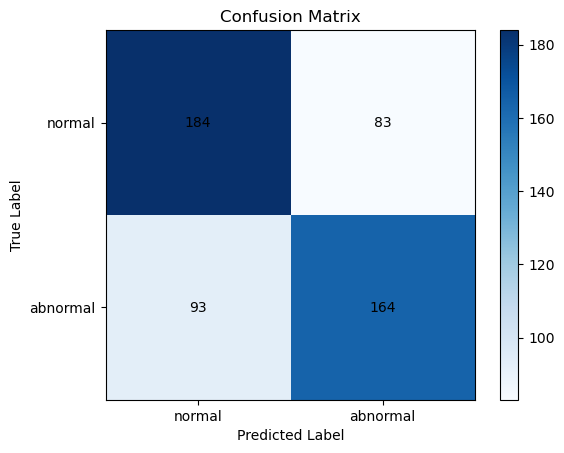

In [60]:
Experiment1 = train(
    model, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.001,       
    epochs=30,    
    l2=0.00     
)


In [61]:
import matplotlib.pyplot as plt

def plot_experiment_history(history, title_prefix="Experiment"):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["loss"], label="Train Loss")
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["precision"], label="Precision")
    plt.plot(epochs, history["recall"], label="Recall")
    plt.plot(epochs, history["f1"], label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title(f"{title_prefix} - Test Metrics vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


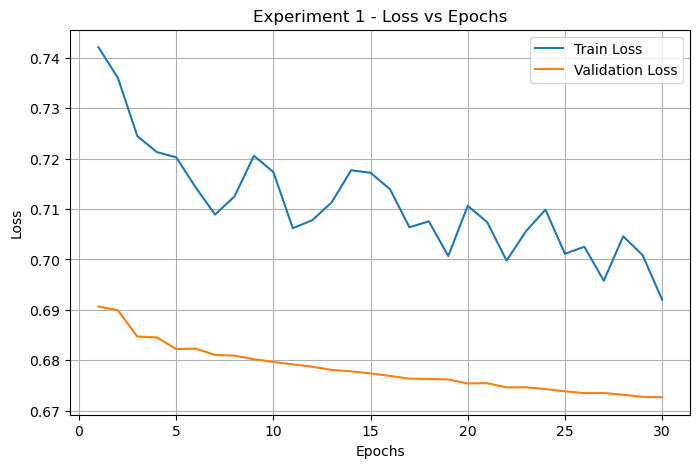

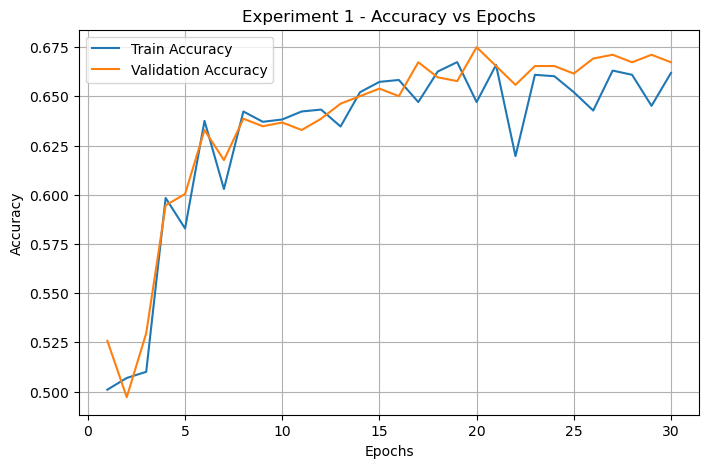

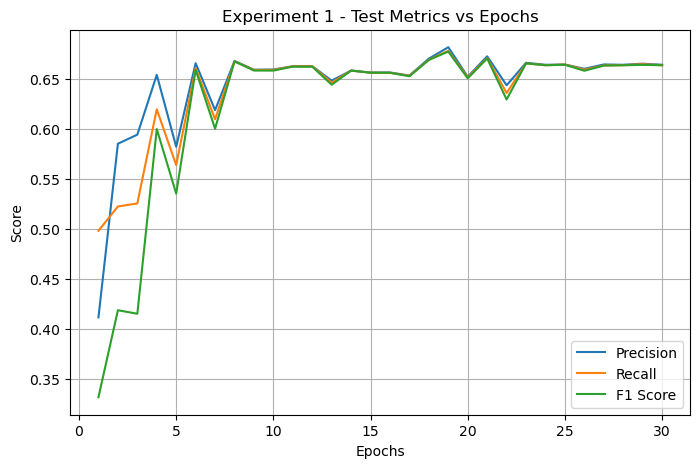

In [62]:
plot_experiment_history(Experiment1, title_prefix="Experiment 1")


**Experiment 2 :**
\
input layer(10,000) -> hidden layer_1 (8000) -> hidden_layer_2 (4000) -> hidden layer_2(2000) ->  hidden_layer_3 (500) -> output layer (2)\
number of epochs = 30
\
learning rate = 0.001
\
l2 = 0.00
\
optimizer = SGD
\
image size = 100x100
\
Dropout = No drop out 
\
Activation function = Sigmoid(), ReLU()


In [63]:
model_exp2 = SimpleNN(input_dim=X_train.shape[1], hidden_dims=[8000, 4000, 2000, 500], output_dim=2, dropout_p=0.0)

In [74]:
model_summary(model_exp2)

Layer (type)        Input → Output       Activation/Dropout     # Parameters
--------------------------------------------------------------------------------
 1 (Linear)     10000 → 8000         ReLU   p=0.0      80008000
 2 (Linear)     8000 → 4000         ReLU   p=0.0      32004000
 3 (Linear)     4000 → 2000         ReLU   p=0.0      8002000
 4 (Linear)     2000 → 500          ReLU   p=0.0      1000500
 5 (Linear)     500 → 2                              1002
--------------------------------------------------------------------------------
Total parameters: 121015502


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30  Loss=0.6999  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30  Loss=0.8984  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/30  Loss=2.3138  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/30  Loss=1.6445  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/30  Loss=1.5915  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/30  Loss=1.3074  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/30  Loss=1.2452  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/30  Loss=1.1969  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/30  Loss=1.1176  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/30  Loss=1.0837  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/30  Loss=1.0493  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/30  Loss=1.0271  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/30  Loss=0.9855  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/30  Loss=0.9626  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/30  Loss=0.9375  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/30  Loss=0.9208  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/30  Loss=0.8985  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/30  Loss=0.8907  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/30  Loss=0.8772  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/30  Loss=0.8690  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21/30  Loss=0.8527  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/30  Loss=0.8430  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/30  Loss=0.8329  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24/30  Loss=0.8291  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/30  Loss=0.8206  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/30  Loss=0.8190  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/30  Loss=0.8087  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/30  Loss=0.8079  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29/30  Loss=0.7980  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/30  Loss=0.7934  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291

=== Final Accuracy ===
Train Accuracy : 0.5081
Validation Accuracy : 0.5258
Test Accuracy  : 0.4905

Confusion Matrix:
 [[  0 267]
 [  0 257]]


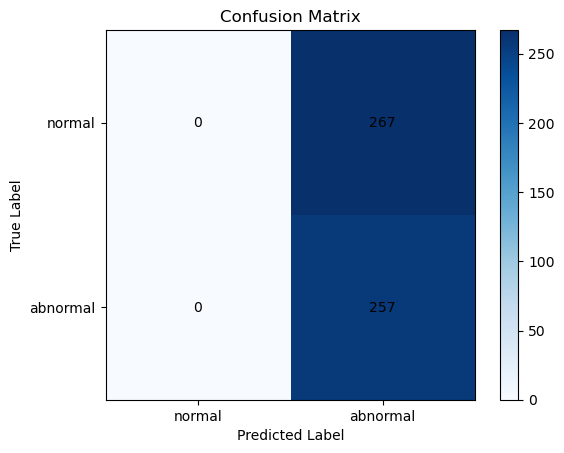

In [65]:
Experiment2 = train(
    model_exp2, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.001,       
    epochs=30,    
    l2=0.00     
)


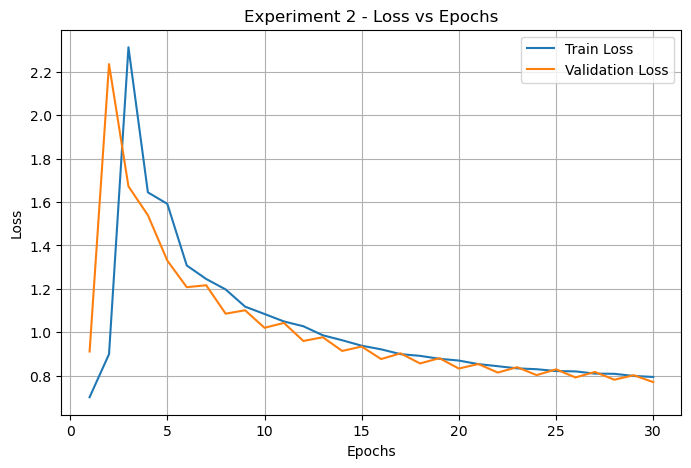

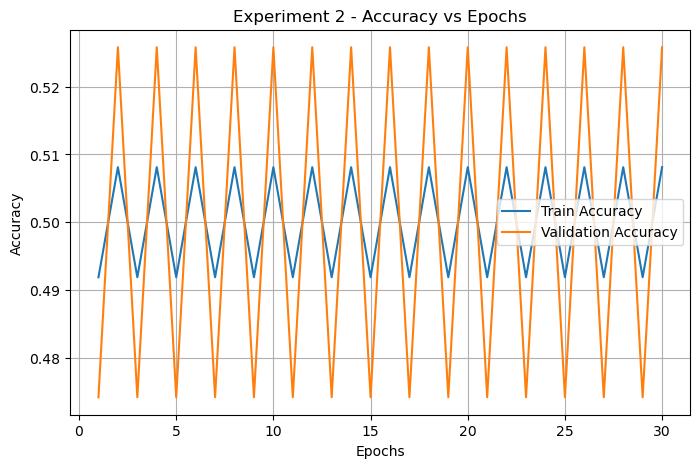

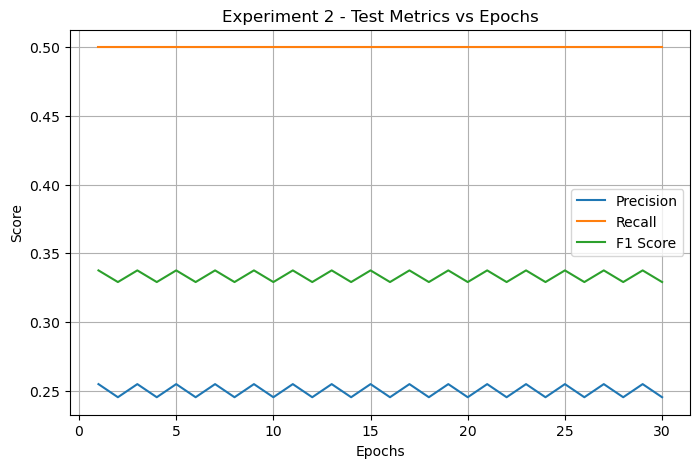

In [66]:
plot_experiment_history(Experiment2, title_prefix="Experiment 2")


**Experiment 3 :**
\
input layer(10,000) -> hidden layer_1 (5000) -> hidden_layer_2(1000) -> output layer (2)\
number of epochs = 30
\
learning rate = 0.01
\
l2 = 0.00
\
optimizer = SGD
\
image size = 100x100
\
Dropout = 20%
\
Activation function = Sigmoid(), ReLU()


In [67]:
model_exp3 = SimpleNN(input_dim=X_train.shape[1], hidden_dims=[5000, 1000, 500], output_dim=2, dropout_p=0.2)

In [75]:
model_summary(model_exp3)

Layer (type)        Input → Output       Activation/Dropout     # Parameters
--------------------------------------------------------------------------------
 1 (Linear)     10000 → 5000         ReLU   p=0.2      50005000
 2 (Linear)     5000 → 1000         ReLU   p=0.2      5001000
 3 (Linear)     1000 → 500          ReLU   p=0.2      500500
 4 (Linear)     500 → 2                              1002
--------------------------------------------------------------------------------
Total parameters: 55507502


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30  Loss=0.9119  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30  Loss=2.5164  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/30  Loss=1.3045  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/30  Loss=0.8471  TrainAcc=0.4919  ValAcc=0.4742  TestAcc=0.5095  Prec=0.2548  Recall=0.5000  F1=0.3375


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/30  Loss=0.7277  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291
Epoch 6/30  Loss=0.7059  TrainAcc=0.5074  ValAcc=0.5239  TestAcc=0.4866  Prec=0.2443  Recall=0.4961  F1=0.3273


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/30  Loss=0.7099  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4905  Prec=0.2452  Recall=0.5000  F1=0.3291
Epoch 8/30  Loss=0.7089  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4885  Prec=0.2447  Recall=0.4981  F1=0.3282
Epoch 9/30  Loss=0.7068  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4885  Prec=0.2447  Recall=0.4981  F1=0.3282
Epoch 10/30  Loss=0.7072  TrainAcc=0.5081  ValAcc=0.5258  TestAcc=0.4885  Prec=0.2447  Recall=0.4981  F1=0.3282
Epoch 11/30  Loss=0.7071  TrainAcc=0.5074  ValAcc=0.5258  TestAcc=0.4866  Prec=0.2443  Recall=0.4961  F1=0.3273
Epoch 12/30  Loss=0.7051  TrainAcc=0.5072  ValAcc=0.5258  TestAcc=0.4885  Prec=0.2447  Recall=0.4981  F1=0.3282
Epoch 13/30  Loss=0.6987  TrainAcc=0.5050  ValAcc=0.5239  TestAcc=0.4866  Prec=0.3692  Recall=0.4960  F1=0.3306
Epoch 14/30  Loss=0.7036  TrainAcc=0.5043  ValAcc=0.5239  TestAcc=0.4866  Prec=0.3692  Recall=0.4960  F1=0.3306
Epoch 15/30  Loss=0.6952  TrainAcc=0.5024  ValAcc=0.5239  TestAcc=0.4866  Prec=0.3692  Recall=0.4960  F1=0.

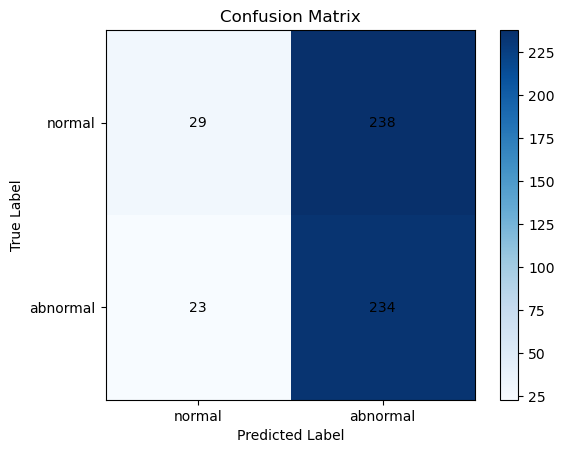

In [70]:
Experiment3 = train(
    model_exp3, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.010,       
    epochs=30,    
    l2=0.00     
)


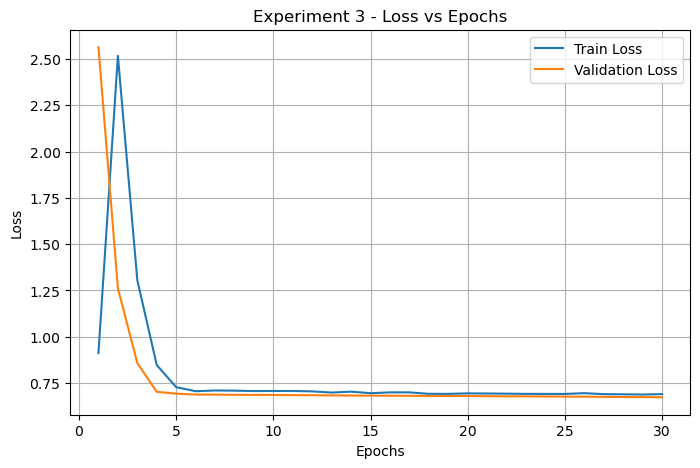

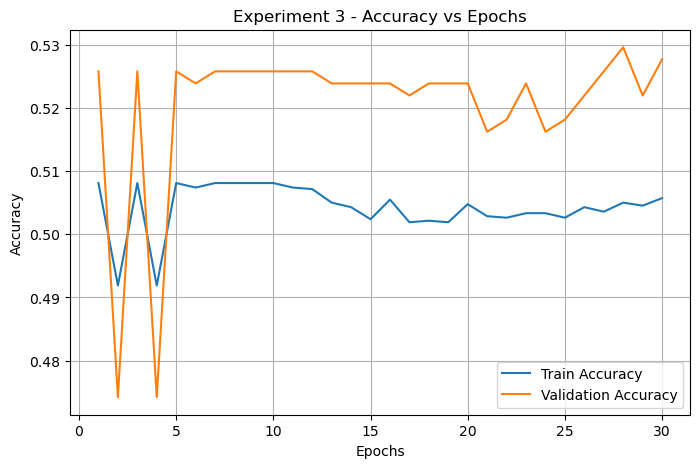

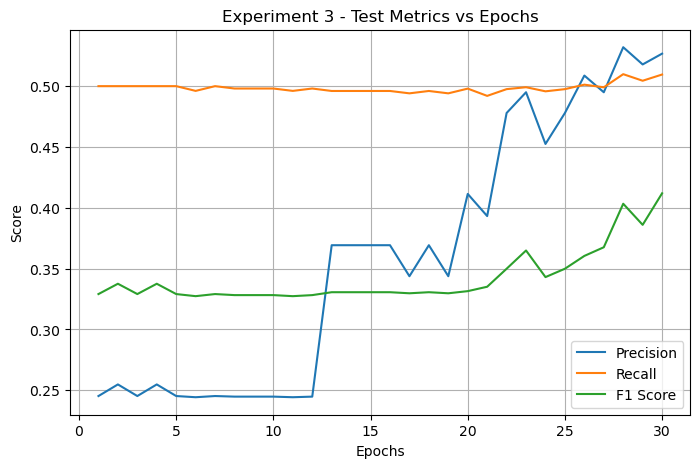

In [71]:
plot_experiment_history(Experiment3, title_prefix="Experiment 3")


Experiment 4 : Since the above experiemnts are stuck at accuracy around 50% hence we might need to experiment 
1. image size
2. batches : Pass the dataset as batches adn not compute gradient descent over the entire dataset 
hence for the next experiment 
image size : 128x128
learning rate : decreasing (0.02)
Architecture: input layer (128x128) -> hidden_layer1 (2048) -> relu()-> drop out 20% -> hidden_layer_2(512) -> reLU() -> drop out 20% -> output layer (2)
3. optimizer : mini batch gradient descent

We will also be computing mini batch gradient descent in order to get optimize results 

In [77]:
def get_batches(X, y, batch_size=64, shuffle=True):
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]


Loading the dataset, changing the shape to be 128x128,  splitting the dataset into train, test and validation

In [76]:
import numpy as np
from PIL import Image
import glob
import os
def load_image(dataset_dir, size=(128,128)):
    X1=[]   
    y1=[] 
    classes={
        "normal" :0,
        "abnormal": 1
    }
    for class_name, class_label in classes.items():
        folder = os.path.join(dataset_dir,class_name)
        image_paths = glob.glob(folder+"/*.png")
        for path in image_paths:
            img = Image.open(path)
            img = Image.open(path).convert('L')
            img = img.resize(size)
            arr = np.array(img, dtype=np.float32)/255.0
            arr = arr.flatten()
            X1.append(arr)
            y1.append(class_label)
    X = np.array(X1)
    Y = np.array(y1)
    return X,Y

X,Y = load_image("C:/Users/HP/Downloads/dataset-fro-programming&mathsforAI/spectrogramprocessedata/heartbeat-dataset")
import numpy as np

def train_val_test_split(X, y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=None):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    train_end = int(N * train_ratio)
    val_end = train_end + int(N * val_ratio)

    train_idx = idx[:train_end]
    val_idx = idx[train_end:val_end]
    test_idx = idx[val_end:]

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, Y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (4188, 16384) (4188,)
Validation: (523, 16384) (523,)
Test: (524, 16384) (524,)


In [85]:
def train(model, X_train, y_train, X_val, y_val, X_test, y_test, lr=0.001, epochs=30, l2=0.0, batch_size=64):

    history = {
        "loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for epoch in range(epochs):
        epoch_loss = 0
        n_samples = 0

        # --- Mini-batch training ---
        for X_batch, y_batch in get_batches(X_train, y_train, batch_size=batch_size):
            # Forward pass
            logits = model.forward(X_batch, training=True)
            probs = softmax(logits)

            # Loss
            loss = cross_entropy(probs, y_batch)
            loss += (l2 / 2) * sum(np.sum(layer.W**2) for layer in model.layers)

            # Backward pass
            grad = softmax_backward(probs, y_batch)
            model.backward(grad, l2=l2)

            # Update weights
            model.update(lr)

            # Accumulate batch loss
            epoch_loss += loss * X_batch.shape[0]
            n_samples += X_batch.shape[0]

        # Average epoch loss
        epoch_loss /= n_samples

        # --- Validation ---
        val_logits = model.forward(X_val, training=False)
        val_probs  = softmax(val_logits)
        val_loss   = cross_entropy(val_probs, y_val)
        val_loss  += (l2 / 2) * sum(np.sum(layer.W**2) for layer in model.layers)

        # --- Predictions ---
        train_preds = model.predict(X_train)
        val_preds   = model.predict(X_val)
        test_preds  = model.predict(X_test)

        # --- Metrics ---
        train_acc = accuracy(y_train, train_preds)
        val_acc   = accuracy(y_val, val_preds)
        test_acc  = accuracy(y_test, test_preds)

        prec = precision_score(y_test, test_preds, average='macro')
        rec  = recall_score(y_test, test_preds, average='macro')
        f1   = f1_score(y_test, test_preds, average='macro')

        # --- Save history ---
        history["loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["test_acc"].append(test_acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1"].append(f1)

        print(f"Epoch {epoch+1}/{epochs}  Loss={epoch_loss:.4f}  "
              f"TrainAcc={train_acc:.4f}  ValAcc={val_acc:.4f}  TestAcc={test_acc:.4f}  "
              f"Prec={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

    # --- Final evaluation ---
    final_train_preds = model.predict(X_train)
    final_val_preds   = model.predict(X_val)
    final_test_preds  = model.predict(X_test)

    print("\n=== Final Accuracy ===")
    print(f"Train Accuracy : {accuracy(y_train, final_train_preds):.4f}")
    print(f"Validation Accuracy : {accuracy(y_val, final_val_preds):.4f}")
    print(f"Test Accuracy  : {accuracy(y_test, final_test_preds):.4f}")

    cm = confusion_matrix(y_test, final_test_preds)
    print("\nConfusion Matrix:\n", cm)
    plot_confusion_matrix(cm)

    return history


In [81]:
def model_summary(model):
    print("Layer (type)        Input → Output       # Parameters")
    print("-"*50)
    total_params = 0
    for i, layer in enumerate(model.layers):
        in_dim, out_dim = layer.W.shape
        params = in_dim * out_dim + out_dim
        total_params += params
        layer_type = "Linear"
        print(f"{i+1:2d} ({layer_type:<6})     {in_dim} → {out_dim:<6}     {params}")
    print("-"*50)
    print(f"Total parameters: {total_params}")


In [79]:
model_exp4 = SimpleNN(input_dim=X_train.shape[1], hidden_dims=[2048, 512], output_dim=2, dropout_p=0.2)

In [84]:
model_summary(model_exp4)

Layer (type)        Input → Output       Activation/Dropout     # Parameters
--------------------------------------------------------------------------------
 1 (Linear)     16384 → 2048         ReLU   p=0.2      33556480
 2 (Linear)     2048 → 512          ReLU   p=0.2      1049088
 3 (Linear)     512 → 2                              1026
--------------------------------------------------------------------------------
Total parameters: 34606594


Epoch 1/30  Loss=0.8903  TrainAcc=0.5224  ValAcc=0.5124  TestAcc=0.5229  Prec=0.7530  Recall=0.5336  F1=0.3989


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30  Loss=0.6925  TrainAcc=0.5062  ValAcc=0.5201  TestAcc=0.5115  Prec=0.2557  Recall=0.5000  F1=0.3384


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/30  Loss=0.6892  TrainAcc=0.5062  ValAcc=0.5201  TestAcc=0.5115  Prec=0.2557  Recall=0.5000  F1=0.3384
Epoch 4/30  Loss=0.6845  TrainAcc=0.5038  ValAcc=0.5182  TestAcc=0.5134  Prec=0.5896  Recall=0.5020  F1=0.3461
Epoch 5/30  Loss=0.6833  TrainAcc=0.6022  ValAcc=0.5985  TestAcc=0.6164  Prec=0.6272  Recall=0.6126  F1=0.6034
Epoch 6/30  Loss=0.6764  TrainAcc=0.6165  ValAcc=0.6272  TestAcc=0.6279  Prec=0.6328  Recall=0.6252  F1=0.6213


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/30  Loss=0.6679  TrainAcc=0.5062  ValAcc=0.5201  TestAcc=0.5115  Prec=0.2557  Recall=0.5000  F1=0.3384
Epoch 8/30  Loss=0.6719  TrainAcc=0.5067  ValAcc=0.4990  TestAcc=0.5038  Prec=0.7481  Recall=0.5149  F1=0.3606
Epoch 9/30  Loss=0.6633  TrainAcc=0.6834  ValAcc=0.7189  TestAcc=0.6718  Prec=0.6967  Recall=0.6756  F1=0.6639
Epoch 10/30  Loss=0.6527  TrainAcc=0.6800  ValAcc=0.7075  TestAcc=0.6851  Prec=0.7443  Recall=0.6906  F1=0.6686
Epoch 11/30  Loss=0.6506  TrainAcc=0.6624  ValAcc=0.6998  TestAcc=0.6584  Prec=0.6606  Recall=0.6595  F1=0.6580
Epoch 12/30  Loss=0.6474  TrainAcc=0.6796  ValAcc=0.7075  TestAcc=0.6870  Prec=0.7456  Recall=0.6925  F1=0.6709
Epoch 13/30  Loss=0.6408  TrainAcc=0.6077  ValAcc=0.6195  TestAcc=0.6279  Prec=0.6346  Recall=0.6248  F1=0.6196
Epoch 14/30  Loss=0.6399  TrainAcc=0.6698  ValAcc=0.7113  TestAcc=0.6870  Prec=0.7703  Recall=0.6932  F1=0.6651
Epoch 15/30  Loss=0.6591  TrainAcc=0.6886  ValAcc=0.7170  TestAcc=0.6813  Prec=0.7080  Recall=0.6852  F1=0.

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/30  Loss=0.6214  TrainAcc=0.5062  ValAcc=0.5201  TestAcc=0.5115  Prec=0.2557  Recall=0.5000  F1=0.3384
Epoch 24/30  Loss=0.6473  TrainAcc=0.5676  ValAcc=0.5851  TestAcc=0.5782  Prec=0.6177  Recall=0.5711  F1=0.5280
Epoch 25/30  Loss=0.6301  TrainAcc=0.6600  ValAcc=0.6883  TestAcc=0.6775  Prec=0.7795  Recall=0.6843  F1=0.6499
Epoch 26/30  Loss=0.6410  TrainAcc=0.6471  ValAcc=0.6673  TestAcc=0.6546  Prec=0.6576  Recall=0.6526  F1=0.6510
Epoch 27/30  Loss=0.6305  TrainAcc=0.5981  ValAcc=0.6195  TestAcc=0.6317  Prec=0.7851  Recall=0.6399  F1=0.5818
Epoch 28/30  Loss=0.6253  TrainAcc=0.5091  ValAcc=0.5182  TestAcc=0.5172  Prec=0.6144  Recall=0.5060  F1=0.3579
Epoch 29/30  Loss=0.6629  TrainAcc=0.6139  ValAcc=0.6444  TestAcc=0.6489  Prec=0.7909  Recall=0.6567  F1=0.6065


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/30  Loss=0.6134  TrainAcc=0.5074  ValAcc=0.5220  TestAcc=0.5115  Prec=0.2557  Recall=0.5000  F1=0.3384

=== Final Accuracy ===
Train Accuracy : 0.5074
Validation Accuracy : 0.5220
Test Accuracy  : 0.5115

Confusion Matrix:
 [[  0 256]
 [  0 268]]


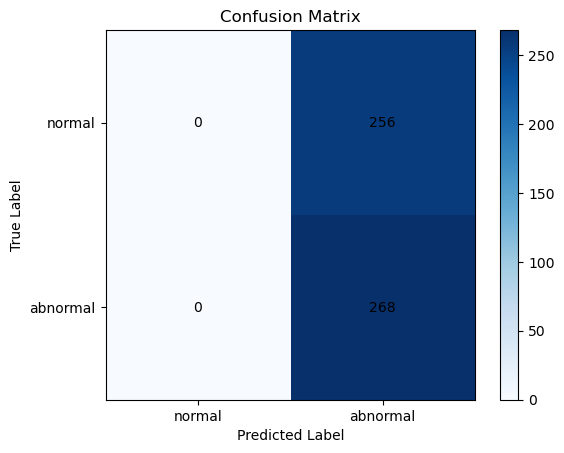

In [86]:
Experiment4 = train(
    model_exp4, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.02,       
    epochs=30,    
    l2=0.00     
)


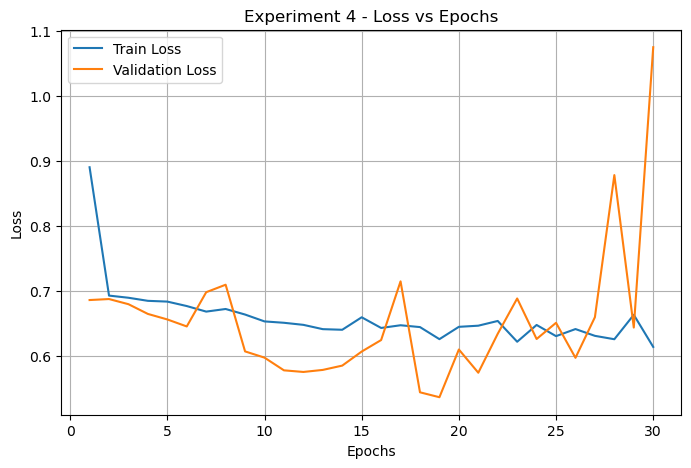

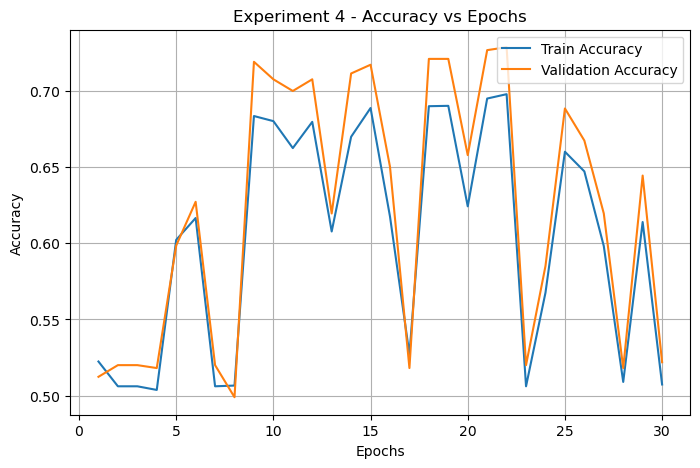

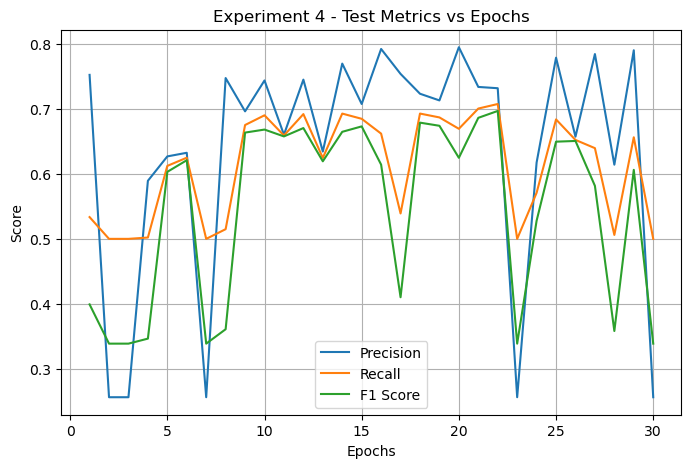

In [87]:
plot_experiment_history(Experiment4, title_prefix="Experiment 4")


Epoch 1/70  Loss=0.6167  TrainAcc=0.6975  ValAcc=0.7304  TestAcc=0.6947  Prec=0.7313  Recall=0.6990  F1=0.6849
Epoch 2/70  Loss=0.5749  TrainAcc=0.6956  ValAcc=0.7247  TestAcc=0.6947  Prec=0.7266  Recall=0.6988  F1=0.6862
Epoch 3/70  Loss=0.5732  TrainAcc=0.6972  ValAcc=0.7285  TestAcc=0.6966  Prec=0.7344  Recall=0.7010  F1=0.6867
Epoch 4/70  Loss=0.5706  TrainAcc=0.6970  ValAcc=0.7304  TestAcc=0.7023  Prec=0.7437  Recall=0.7069  F1=0.6920
Epoch 5/70  Loss=0.5689  TrainAcc=0.6960  ValAcc=0.7208  TestAcc=0.6889  Prec=0.7180  Recall=0.6929  F1=0.6809
Epoch 6/70  Loss=0.5679  TrainAcc=0.6922  ValAcc=0.7247  TestAcc=0.6966  Prec=0.7455  Recall=0.7015  F1=0.6839
Epoch 7/70  Loss=0.5622  TrainAcc=0.6968  ValAcc=0.7304  TestAcc=0.7004  Prec=0.7423  Recall=0.7050  F1=0.6898
Epoch 8/70  Loss=0.5673  TrainAcc=0.6944  ValAcc=0.7266  TestAcc=0.7004  Prec=0.7461  Recall=0.7052  F1=0.6888
Epoch 9/70  Loss=0.5663  TrainAcc=0.6977  ValAcc=0.7266  TestAcc=0.6889  Prec=0.7153  Recall=0.6927  F1=0.6817
E

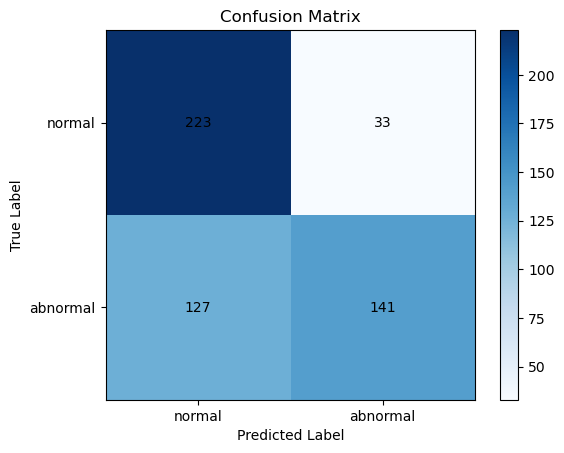

In [88]:
Experiment5 = train(
    model_exp4, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.001,       
    epochs=70,    
    l2=0.00     
)


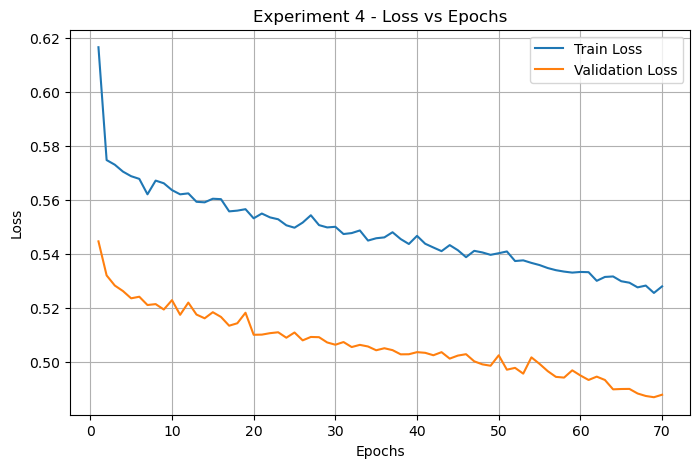

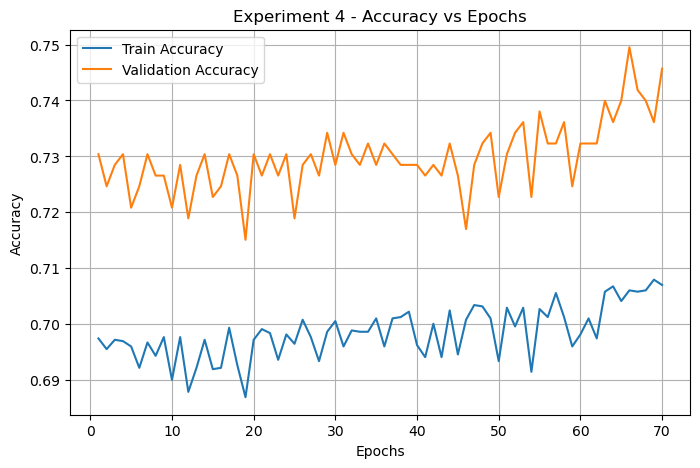

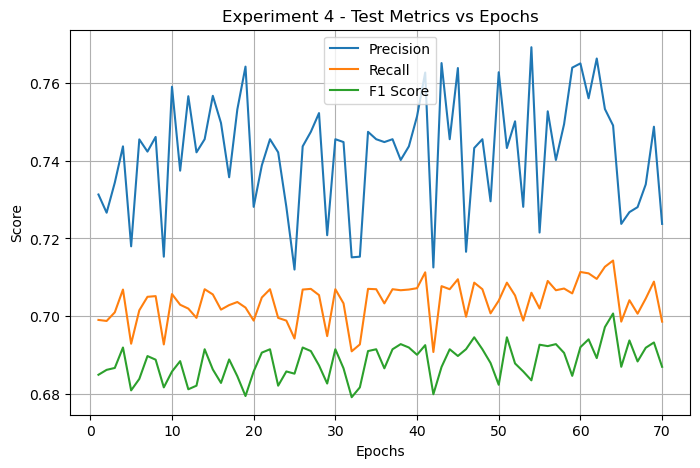

In [89]:
plot_experiment_history(Experiment5, title_prefix="Experiment 4")


In [90]:
class SimpleNN:
    def __init__(self, input_dim, output_dim=2, dropout_p=0.2):
        # Define layers
        self.l1 = Linear(input_dim, 2048)
        self.a1 = ReLU()
        self.d1 = Dropout(p=dropout_p)

        self.l2 = Linear(2048, 512)
        self.a2 = ReLU()
        self.d2 = Dropout(p=dropout_p)

        self.l3 = Linear(512, output_dim)  # output layer (no activation, no dropout)
        self.layers = [self.l1, self.l2, self.l3]

    def forward(self, x, training=True):
        z1 = self.l1.forward(x)
        a1 = self.a1.forward(z1)
        d1 = self.d1.forward(a1, training=training)

        z2 = self.l2.forward(d1)
        a2 = self.a2.forward(z2)
        d2 = self.d2.forward(a2, training=training)

        z3 = self.l3.forward(d2)
        return z3  # logits

    def backward(self, grad, l2=0.0):
        grad = self.l3.backward(grad, l2=l2)

        grad = self.d2.backward(grad)
        grad = self.a2.backward(grad)
        grad = self.l2.backward(grad, l2=l2)

        grad = self.d1.backward(grad)
        grad = self.a1.backward(grad)
        grad = self.l1.backward(grad, l2=l2)

        return grad

    def update(self, lr):
        for layer in [self.l1, self.l2, self.l3]:
            layer.W -= lr * layer.dW
            layer.b -= lr * layer.db

    def predict(self, X):
        logits = self.forward(X, training=False)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)


In [91]:
def confusion_matrix(y_true, y_pred, num_classes=2):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes=['normal', 'abnormal']):
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # write numbers inside boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [92]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [93]:
def get_batches(X, y, batch_size=64, shuffle=True):
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]


In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Mini-batch generator
def get_batches(X, y, batch_size=64, shuffle=True):
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]

def train(model, X_train, y_train, X_test, y_test, lr=0.001, epochs=25, l2=0.0, batch_size=64):

    history = {
        "loss": [],
        "train_acc": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for epoch in range(epochs):
        epoch_loss = 0
        n_samples = 0

        # --- Mini-batch training ---
        for X_batch, y_batch in get_batches(X_train, y_train, batch_size=batch_size):
            # Forward
            logits = model.forward(X_batch, training=True)
            probs = softmax(logits)

            # Loss
            loss = cross_entropy(probs, y_batch)
            loss += (l2/2) * sum(np.sum(layer.W**2) for layer in model.layers)
            epoch_loss += loss * X_batch.shape[0]
            n_samples += X_batch.shape[0]

            # Backward
            grad = softmax_backward(probs, y_batch)
            model.backward(grad, l2=l2)

            # Update
            model.update(lr)

        # Average loss over the epoch
        epoch_loss /= n_samples

        # --- Evaluate metrics on full train/test sets ---
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        train_acc = accuracy(y_train, train_preds)
        test_acc = accuracy(y_test, test_preds)

        prec = precision_score(y_test, test_preds, average='macro')
        rec  = recall_score(y_test, test_preds, average='macro')
        f1   = f1_score(y_test, test_preds, average='macro')

        # Save history
        history["loss"].append(epoch_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1"].append(f1)

        print(f"Epoch {epoch+1}/{epochs}  Loss={epoch_loss:.4f}  "
              f"TrainAcc={train_acc:.4f}  TestAcc={test_acc:.4f}  "
              f"Prec={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

    # --- Final evaluation ---
    final_train_preds = model.predict(X_train)
    final_test_preds = model.predict(X_test)
    final_train_acc = accuracy(y_train, final_train_preds)
    final_test_acc  = accuracy(y_test, final_test_preds)

    print("\n=== Final Accuracy ===")
    print(f"Train Accuracy : {final_train_acc:.4f}")
    print(f"Test Accuracy  : {final_test_acc:.4f}")

    cm = confusion_matrix(y_test, final_test_preds)
    print("\nConfusion Matrix:\n", cm)
    plot_confusion_matrix(cm)

    return history


In [95]:
def model_summary(model):
    print("Layer (type)        Input → Output       # Parameters")
    print("-"*50)
    total_params = 0
    for i, layer in enumerate(model.layers):
        in_dim, out_dim = layer.W.shape
        params = in_dim * out_dim + out_dim
        total_params += params
        layer_type = "Linear"
        print(f"{i+1:2d} ({layer_type:<6})     {in_dim} → {out_dim:<6}     {params}")
    print("-"*50)
    print(f"Total parameters: {total_params}")


In [96]:
model = SimpleNN(input_dim=X_train.shape[1], output_dim=2, dropout_p=0.2)

In [97]:
model_summary(model)

Layer (type)        Input → Output       # Parameters
--------------------------------------------------
 1 (Linear)     16384 → 2048       33556480
 2 (Linear)     2048 → 512        1049088
 3 (Linear)     512 → 2          1026
--------------------------------------------------
Total parameters: 34606594


In [98]:
model = SimpleNN(input_dim=X_train.shape[1], output_dim=2, dropout_p=0.2)

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/90  Loss=0.7482  TrainAcc=0.5064  TestAcc=0.5115  Prec=0.2557  Recall=0.5000  F1=0.3384
Epoch 2/90  Loss=0.7029  TrainAcc=0.5683  TestAcc=0.5859  Prec=0.7526  Recall=0.5950  F1=0.5144
Epoch 3/90  Loss=0.6914  TrainAcc=0.6691  TestAcc=0.6622  Prec=0.7216  Recall=0.6679  F1=0.6425


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/90  Loss=0.6788  TrainAcc=0.5062  TestAcc=0.5115  Prec=0.2557  Recall=0.5000  F1=0.3384
Epoch 5/90  Loss=0.6780  TrainAcc=0.5501  TestAcc=0.5477  Prec=0.5761  Recall=0.5398  F1=0.4817
Epoch 6/90  Loss=0.6584  TrainAcc=0.5790  TestAcc=0.6050  Prec=0.6376  Recall=0.5989  F1=0.5722
Epoch 7/90  Loss=0.6586  TrainAcc=0.6867  TestAcc=0.6775  Prec=0.7152  Recall=0.6821  F1=0.6660
Epoch 8/90  Loss=0.6543  TrainAcc=0.6220  TestAcc=0.6603  Prec=0.7897  Recall=0.6678  F1=0.6234


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/90  Loss=0.6443  TrainAcc=0.5081  TestAcc=0.5115  Prec=0.2557  Recall=0.5000  F1=0.3384
Epoch 10/90  Loss=0.6348  TrainAcc=0.6800  TestAcc=0.6832  Prec=0.6839  Recall=0.6837  F1=0.6832
Epoch 11/90  Loss=0.6407  TrainAcc=0.6595  TestAcc=0.6660  Prec=0.6694  Recall=0.6641  F1=0.6626
Epoch 12/90  Loss=0.6372  TrainAcc=0.5800  TestAcc=0.5992  Prec=0.6413  Recall=0.5926  F1=0.5580
Epoch 13/90  Loss=0.6265  TrainAcc=0.6614  TestAcc=0.6832  Prec=0.7750  Recall=0.6897  F1=0.6589
Epoch 14/90  Loss=0.6263  TrainAcc=0.6944  TestAcc=0.7004  Prec=0.7061  Recall=0.7021  F1=0.6993
Epoch 15/90  Loss=0.6252  TrainAcc=0.5771  TestAcc=0.6011  Prec=0.6784  Recall=0.5933  F1=0.5429
Epoch 16/90  Loss=0.6094  TrainAcc=0.6361  TestAcc=0.6431  Prec=0.6600  Recall=0.6391  F1=0.6294
Epoch 17/90  Loss=0.6194  TrainAcc=0.6827  TestAcc=0.6794  Prec=0.6802  Recall=0.6783  F1=0.6780
Epoch 18/90  Loss=0.6137  TrainAcc=0.6638  TestAcc=0.6832  Prec=0.7715  Recall=0.6896  F1=0.6596
Epoch 19/90  Loss=0.6070  Train

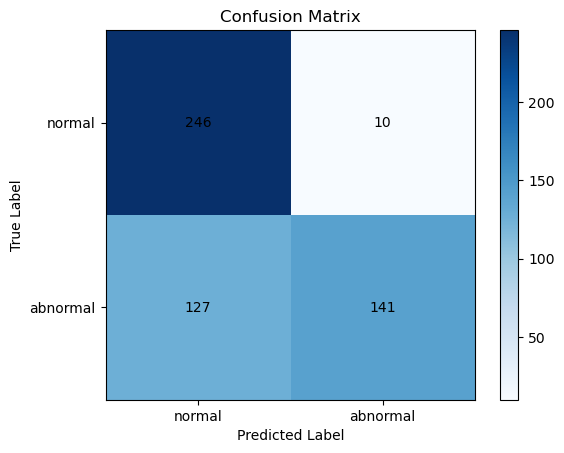

In [99]:
history = train(
    model, 
    X_train, y_train, 
    X_test, y_test,
    lr=0.001,       # learning rate
    epochs=90,      # number of epochs
    l2=0.00      # L2 regularization strength

)


In [102]:
import matplotlib.pyplot as plt

def plot_experiment_history(history, title_prefix="Experiment"):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["loss"], label="Train Loss")
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["precision"], label="Precision")
    plt.plot(epochs, history["recall"], label="Recall")
    plt.plot(epochs, history["f1"], label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title(f"{title_prefix} - Test Metrics vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


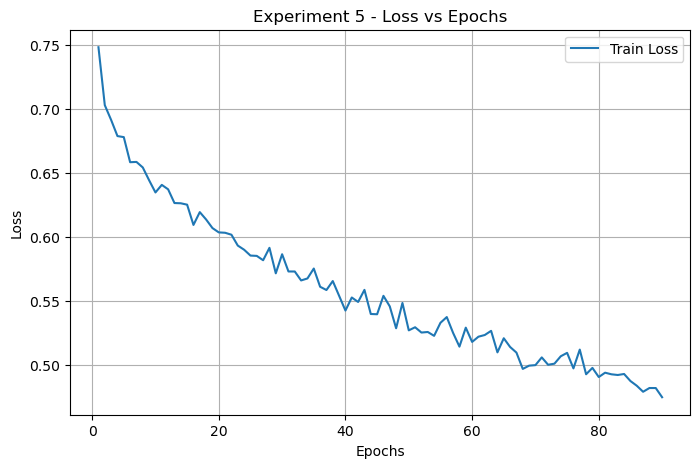

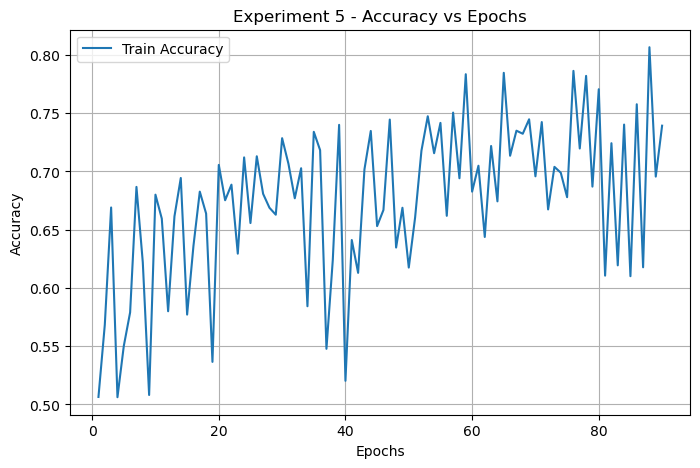

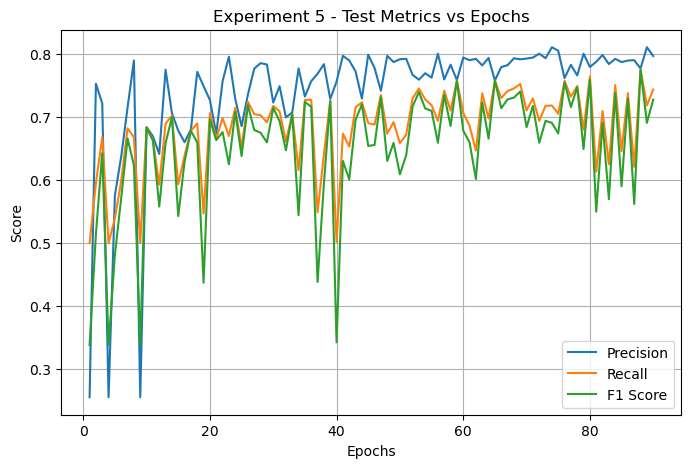

In [103]:
plot_experiment_history(history, title_prefix="Experiment 5")

Epoch 1/90  Loss=0.7265  TrainAcc=0.5069  TestAcc=0.5100  Prec=0.7517  Recall=0.5133  F1=0.3607
Epoch 2/90  Loss=0.7041  TrainAcc=0.6597  TestAcc=0.6485  Prec=0.7732  Recall=0.6508  F1=0.6051
Epoch 3/90  Loss=0.6761  TrainAcc=0.6165  TestAcc=0.6036  Prec=0.6109  Recall=0.6027  F1=0.5958
Epoch 4/90  Loss=0.6626  TrainAcc=0.6743  TestAcc=0.6533  Prec=0.7475  Recall=0.6553  F1=0.6185
Epoch 5/90  Loss=0.6615  TrainAcc=0.6867  TestAcc=0.6628  Prec=0.7192  Recall=0.6645  F1=0.6411
Epoch 6/90  Loss=0.6481  TrainAcc=0.6798  TestAcc=0.6676  Prec=0.6722  Recall=0.6681  F1=0.6658
Epoch 7/90  Loss=0.6448  TrainAcc=0.6535  TestAcc=0.6447  Prec=0.7854  Recall=0.6470  F1=0.5968
Epoch 8/90  Loss=0.6348  TrainAcc=0.6915  TestAcc=0.6638  Prec=0.7258  Recall=0.6655  F1=0.6404
Epoch 9/90  Loss=0.6368  TrainAcc=0.6936  TestAcc=0.6667  Prec=0.7343  Recall=0.6684  F1=0.6422
Epoch 10/90  Loss=0.6296  TrainAcc=0.6196  TestAcc=0.6151  Prec=0.7817  Recall=0.6176  F1=0.5508
Epoch 11/90  Loss=0.6286  TrainAcc=0.59

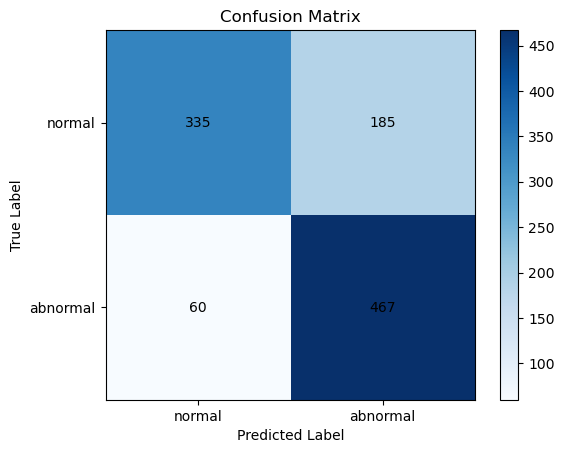

In [19]:
history = train(
    model, 
    X_train, y_train, 
    X_test, y_test,
    lr=0.001,       # learning rate
    epochs=90,      # number of epochs
    l2=0.00      # L2 regularization strength

)


In [84]:
X_test_std = X_test - np.mean(X_train, axis=0)  # use train mean
X_test_pca = pca.transform(X_test_std)


In [85]:
print(X_test_pca.shape)

(1047, 1939)


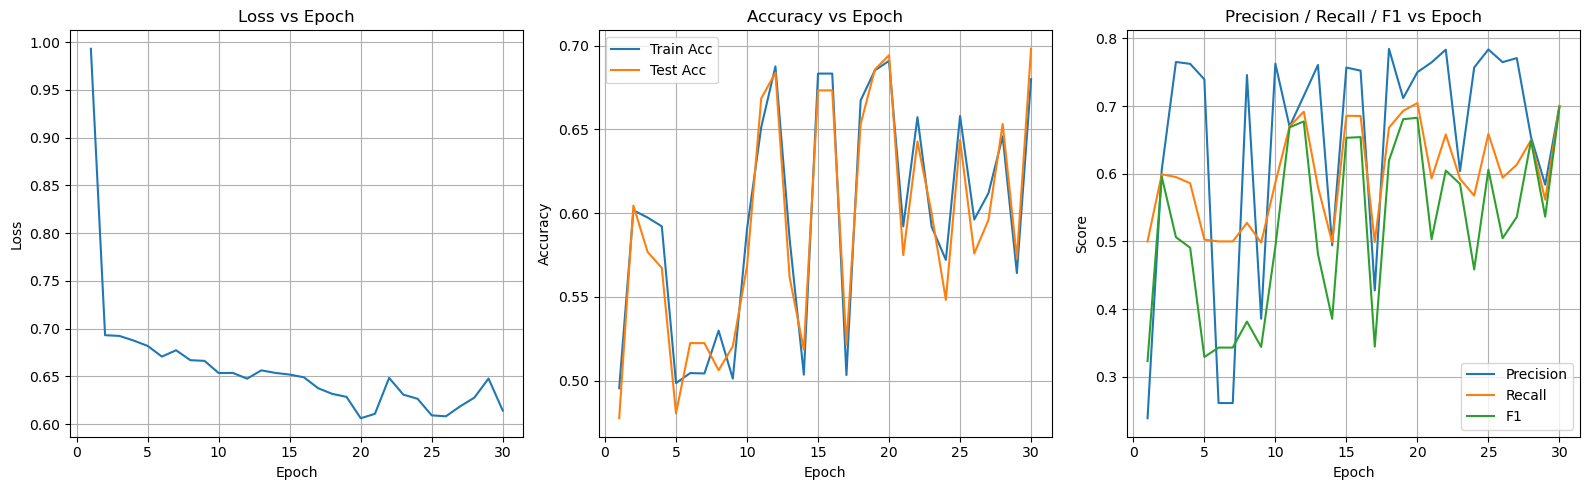

In [42]:
plot_metrics(history)


For the same experiment with 90 epochs

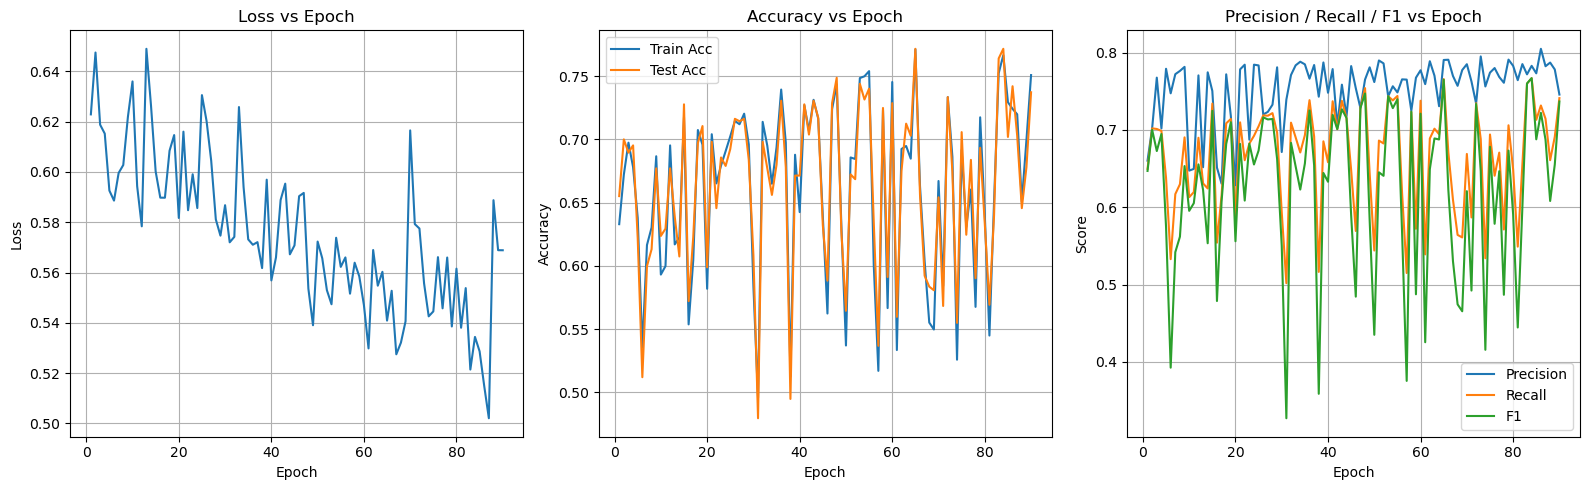

In [44]:
plot_metrics(history)

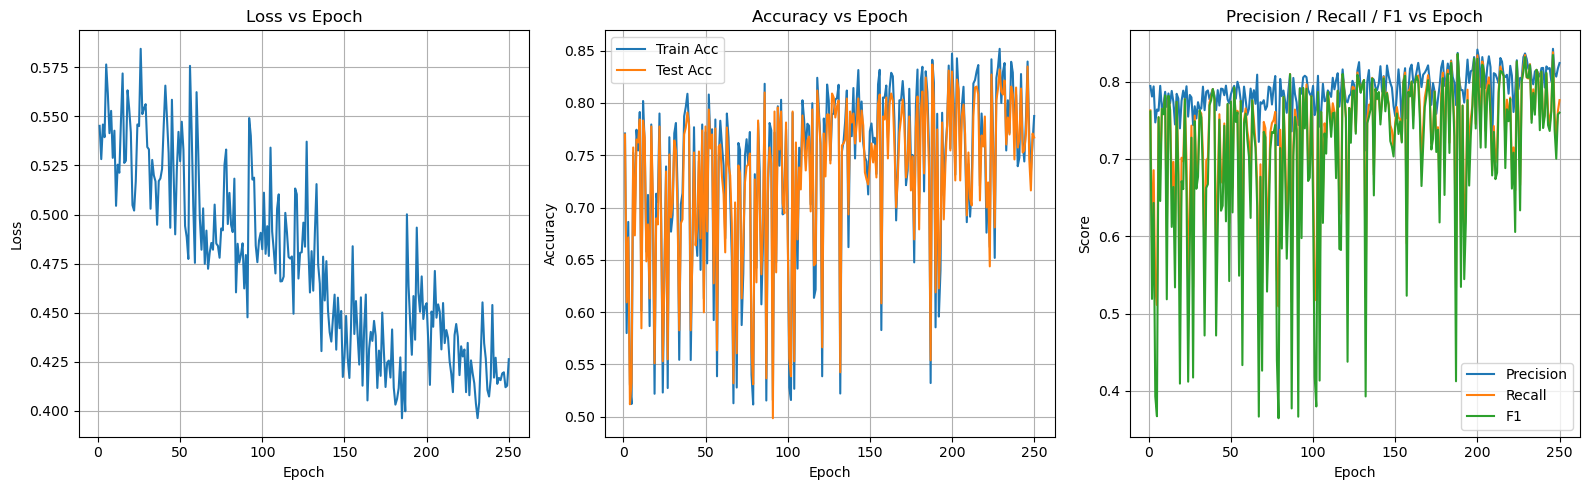

In [46]:
plot_metrics(history)

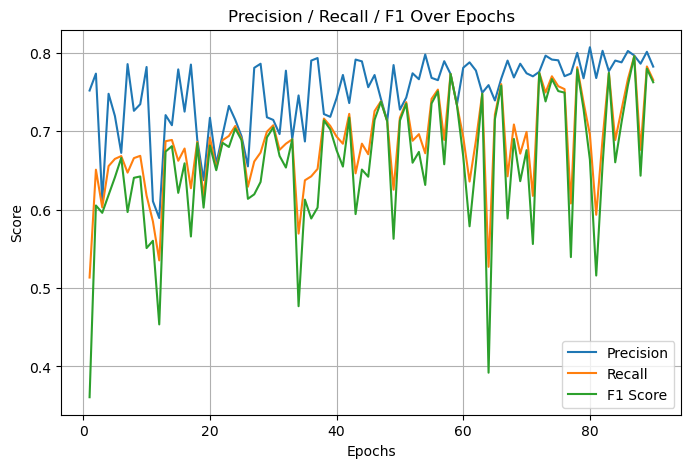

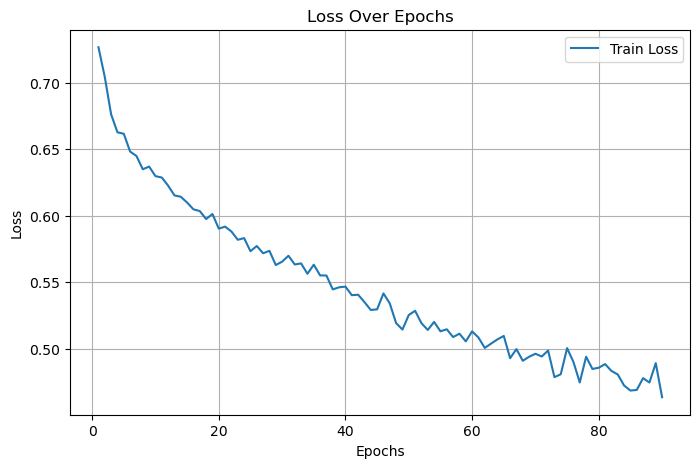

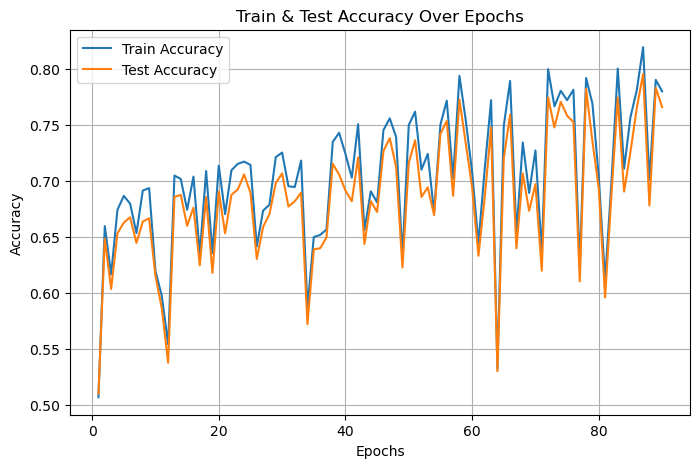

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["loss"]) + 1)

# ---------------------------------------------------------
# 1. Precision, Recall, F1 over epochs
# ---------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, history["precision"], label='Precision')
plt.plot(epochs, history["recall"], label='Recall')
plt.plot(epochs, history["f1"], label='F1 Score')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 2. Loss over epochs
# ---------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, history["loss"], label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 3. Accuracy over epochs (Train vs Test)
# ---------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, history["train_acc"], label='Train Accuracy')
plt.plot(epochs, history["test_acc"], label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train & Test Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


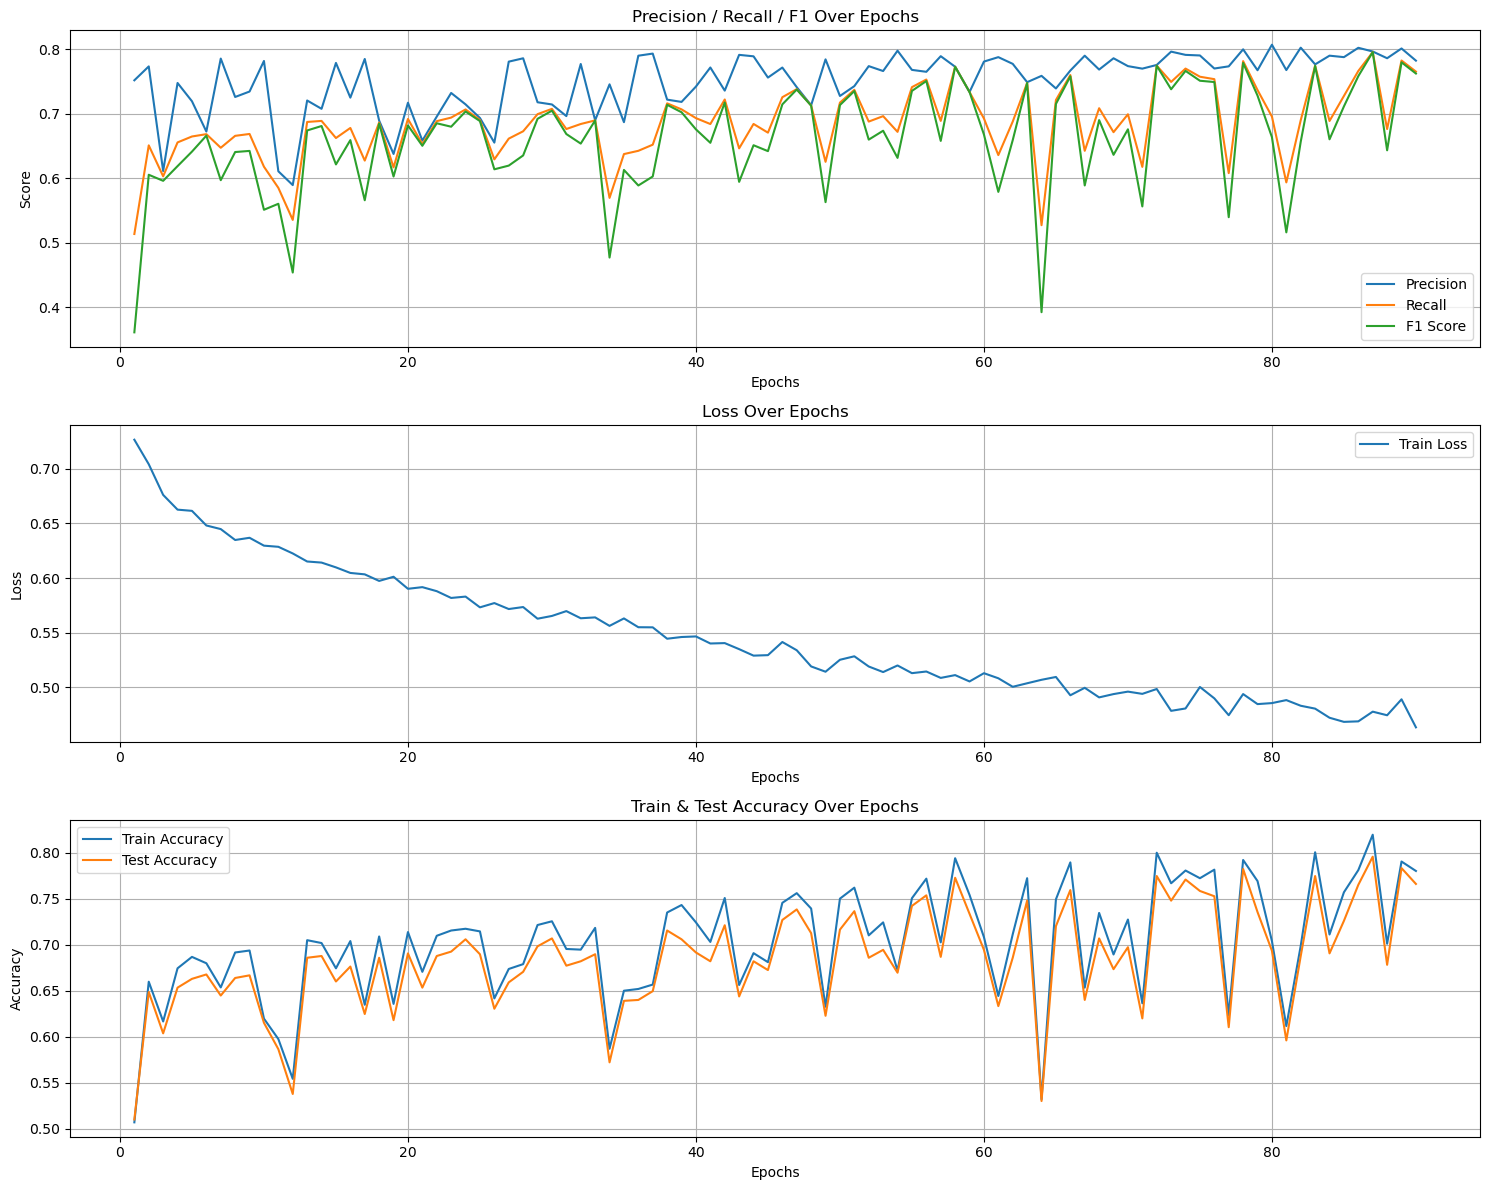

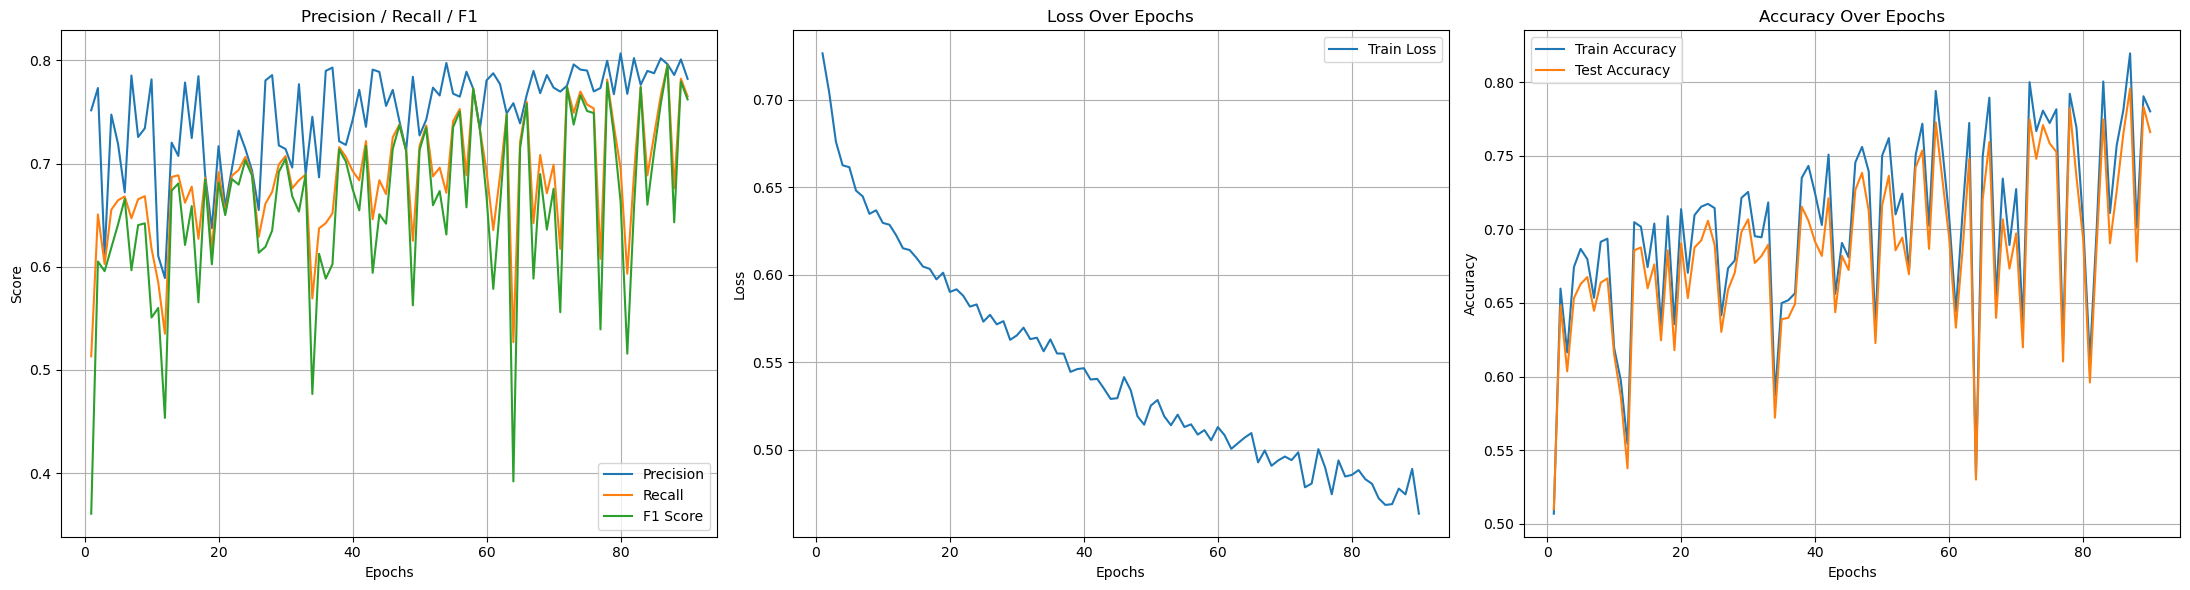

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["loss"]) + 1)

plt.figure(figsize=(22, 6))

# ---------------------------------------------------------
# 1. Precision, Recall, F1
# ---------------------------------------------------------
plt.subplot(1, 3, 1)
plt.plot(epochs, history["precision"], label='Precision')
plt.plot(epochs, history["recall"], label='Recall')
plt.plot(epochs, history["f1"], label='F1 Score')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Precision / Recall / F1")
plt.legend()
plt.grid(True)

# ---------------------------------------------------------
# 2. Loss
# ---------------------------------------------------------
plt.subplot(1, 3, 2)
plt.plot(epochs, history["loss"], label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)

# ---------------------------------------------------------
# 3. Accuracy
# ---------------------------------------------------------
plt.subplot(1, 3, 3)
plt.plot(epochs, history["train_acc"], label='Train Accuracy')
plt.plot(epochs, history["test_acc"], label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
